<font size="8"> **Sea ice seasonality in the Southern Ocean** </font>   
This script calculates days of sea ice advance, retreat, and total sea ice duration over the sea ice season (February 15 to February 14) in the Southern Ocean using outputs from ACCESS-OM2-01.  

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
#Ensure you update this filepath if you have saved these notebooks elsewhere in your machine
os.chdir(os.path.expanduser('~/ACCESS-OM2-01_EcologicallyRelevantVariables/Scripts'))

You can print your working directory using the chunk below to make sure you are in the correct folder containing these notebooks.

In [ ]:
!pwd

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#Loading and manipulating data
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import calendar
from glob import glob
import os
import re
from dask.distributed import Client, progress
import geopandas
import string
from itertools import cycle
import cftime
import xesmf as xe
import rioxarray
import scipy.stats as ss

#Analysis module
import ZonalStatsFunctions as zsf

#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import matplotlib.cm as mcm
import geopandas
#Show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

## Parallelising work
Start a cluster that uses multiple cores to parallelise work. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [2]:
client = Client(n_workers = 12)

## Setting up variables to access ACCESS-OM2-01 model outputs

Create a Cosima Cookbook session to access databases

In [26]:
session = cc.database.create_session()

A list of experiment outputs available through the Cosima Cookbook can be accessed using `cc.querying.get_experiments(session)`. Use the argument `all = True` to get a detailed list of available experiments.  
Variables included in each experiment can be obtained through `cc.querying.get_variables(session, experiment, frequency)`.

In [3]:
varDict =  {'var_id': 'aice',
            'model': 'ACCESS-OM2-01',
            'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
            'freq': '1 daily',
            'start_date': range(1965, 2018, 1),
            'offset': np.nan,
            'long_name': 'sea ice seasonality',
            'short_name': 'SIS',
            'unit': 'days',
            'CICE_data': True,
            'climatologies': r'/g/data/v45/la6889/Calculations/SI_seasons/Climatologies',
            'clim_fig': r'/g/data/v45/la6889/Figures/SI_seasons/Climatologies',
            'linear_trends': r'/g/data/v45/la6889/Calculations/SI_seasons/LinearTrends',
            'std_err': r'/g/data/v45/la6889/Calculations/SI_seasons/Std_Errors',
            'lm_fig': r'/g/data/v45/la6889/Figures/SI_seasons/LinearTrends',
            'clipped_data': r'/g/data/v45/la6889/Calculations/SI_seasons/ClippedMEASOregions/',
            'year_fig': r'/g/data/v45/la6889/Figures/SI_seasons/Yearly',
            'yearly': r'/g/data/v45/la6889/Calculations/SI_seasons/Yearly',
            'decadal': r'/g/data/v45/la6889/Calculations/SI_seasons/Decades',
            'anomalies': r'/g/data/v45/la6889/Calculations/SI_seasons/Anomalies',
            'decades': range(1965, 2019, 10),
            'res': '0.1°'}

## Sea ice season calculations

### From model outputs

In [6]:
#Defining path where calculations will be saved
dir_out = varDict['yearly']

#Applying calculation for every year
for yr in varDict['start_date']:
    #Loading daily ice data
    SO = zsf.getACCESSdata(varDict['var_id'], str(yr), str(yr+1), 
                           freq = varDict['freq'], ses = session,
                           minlat = -90, maxlat = -45, exp = varDict['expt'], 
                           ice_data = True)
    SO = zsf.corrlong(SO)
    #Calculate sea ice seasons
    adv, ret, sea = zsf.SeaIceAdvArrays(array = SO, dir_out = dir_out)
    del SO, adv, ret, sea

### From observations

In [ ]:
#Location of observation-based sea ice concentration
fileList = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Location where output files will be saved
dir_out = r'/g/data/v45/la6889/Observations/SIS'

#Load observational data
iceObs = [xr.open_dataarray(f) for f in fileList]
iceObs = xr.concat(iceObs, dim = 'time')

#Calculate sea ice seasons and store in disk
for yr in varDict['start_date']:
    obs = iceObs.sel(time = slice(str(yr), str(yr+1)))
    zsf.SeaIceAdvArrays(obs, dir_out = dir_out)

## Loading previously calculated seasons to avoid recalculations

### Model

In [6]:
#Location of files
mod_file = sorted(glob(os.path.join(varDict['yearly'], '*.nc')))

#Get list of files
adv = [xr.open_dataarray(f) for f in mod_file if 'Adv' in f]
ret = [xr.open_dataarray(f) for f in mod_file if 'Ret' in f]
dur = [xr.open_dataarray(f) for f in mod_file if 'Dur' in f]

#Save them in a dictionary
mod = {}
mod['advance'] = xr.concat(adv, dim = 'time')
mod['retreat'] = xr.concat(ret, dim = 'time')
mod['duration'] = xr.concat(dur, dim = 'time')

### Observations

In [7]:
#Location of files
obs_file = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/*.nc'))

#Get list of files
adv = [xr.open_dataarray(f) for f in obs_file if 'Adv' in f]
ret = [xr.open_dataarray(f) for f in obs_file if 'Ret' in f]
dur = [xr.open_dataarray(f) for f in obs_file if 'Dur' in f]

#Save them in a dictionary
obs = {}
obs['advance'] = xr.concat(adv, dim = 'time')
obs['retreat'] = xr.concat(ret, dim = 'time')
obs['duration'] = xr.concat(dur, dim = 'time')

# Loading MEASO regions to overlay them on plots

<AxesSubplot:>

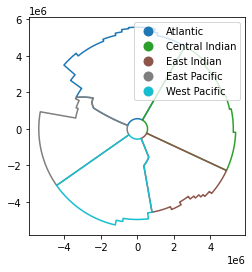

In [7]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Get sector names from shapefile
sectors = np.unique(MEASO.sector)

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(sectors):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Transforming geoseries into geodataframe to add region names
#and adding a new column with the names of the sectors
MEASO_fixed = geopandas.GeoDataFrame(geometry = MEASO_fixed).\
assign(sector = sectors)
        
#Checking results
MEASO_fixed.plot(column = 'sector', legend = True)

## Comparing model and observations

### Regridding model outputs to match observations (coarsening data) and calculating differences

In [31]:
#Rename coordinates in observation based and model based SIC
#Empty list tofilelistre renamed model data
model_prep = {}
obs_prep = {}

#Rename coordinates to match observations
for key in mod:
    #Cropping model outputs between 50S and 90S
    model_prep[key] = mod[key].sel(time = slice('1979', '2017')).\
    rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}).\
    sel(lat = slice(-90, -50))
    #Renaming coordinates from observations prior to regridding
    obs_prep[key] = obs[key].sel(time = slice('1979', '2017')).\
    rename({'longitude': 'lon', 'latitude': 'lat'})

In [26]:
#Regridder only calculated once as the same will be applied for all seasons
reg_coarse = xe.Regridder(model_prep[key], obs_prep[key], 'bilinear')

#Ensuring folder to save regridded data exists
folder_out = os.path.join(varDict['climatologies'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Empty list to store regridded model data, climatologies and biases
seasonal_clim_mod = {}
seasonal_clim_obs = {}
clim_dif = {}
reg_mod = {}

#Apply regridder
for key in model_prep:
    reg_mod[key] = reg_coarse(model_prep[key])
    reg_mod[key]['ygrid'] = obs_prep[key].ygrid
    reg_mod[key]['xgrid'] = obs_prep[key].xgrid
    fn = f'SISeasons_regridded-mod_{key}_1979-2018.nc'
    reg_mod[key].to_netcdf(os.path.join(folder_out, fn))
    #Calculate seasonal climatologies SIC and transform to percentages
    seasonal_clim_mod[key] = reg_mod[key].mean('time')
    seasonal_clim_obs[key] = obs_prep[key].mean('time')
    #Calculate differences in SIC
    clim_dif[key] = seasonal_clim_mod[key]-seasonal_clim_obs[key]

## Defining seasons

In [8]:
seasonNames = {'advance': 'Sea ice advance', 
              'retreat': 'Sea ice retreat', 
              'duration': 'Sea ice duration'}

In [11]:
#Checking minimum and maximum values per SI season
for i in clim_dif:
    print(clim_dif[i].min().values, clim_dif[i].max().values)

## Plotting sea ice seasons

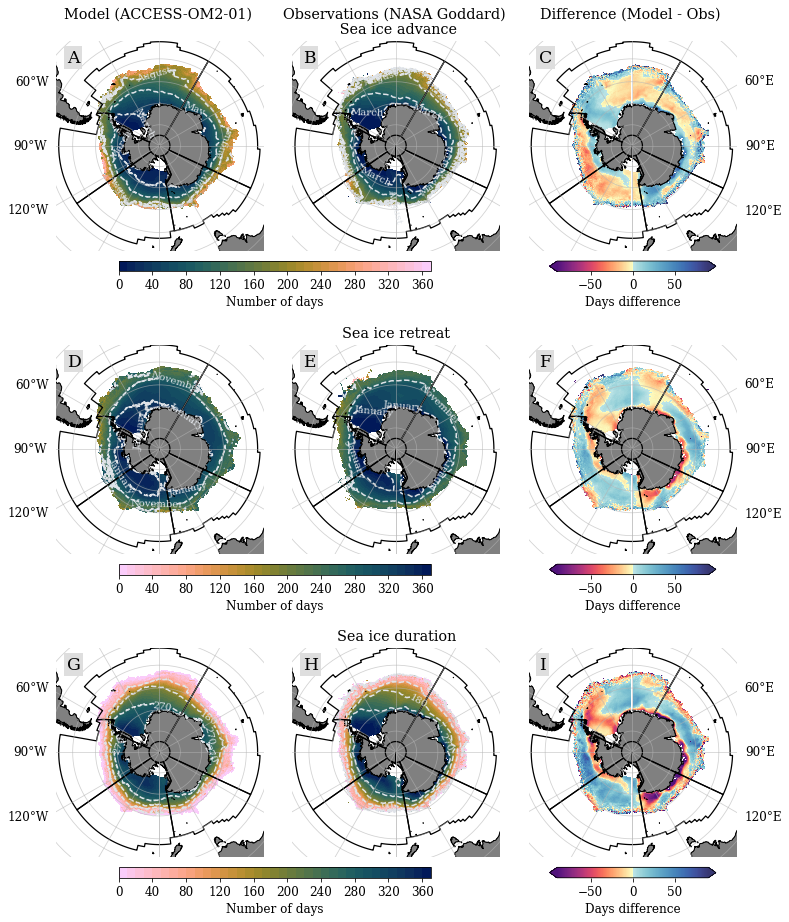

In [28]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -90, vcenter = 0, vmax = 90)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'batlow', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'advance': 'Sea ice advance', 
              'retreat': 'Sea ice retreat', 
              'duration': 'Sea ice duration'}

data = ['Model (ACCESS-OM2-01)', 
        'Observations (NASA Goddard)',
        'Difference (Model - Obs)']

counter = zip(cycle(data), np.repeat(list(seasonNames), len(data)))
    
#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = len(seasonNames),
                       ncols = len(data))
#Change the width between each plot
gs.update(wspace = 0.05, hspace = 0.45)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, coord in enumerate(counter):  
    ax[i] = fig.add_subplot(gs[i], 
                            projection = ccrs.SouthPolarStereo())
    model = mod[coord[1]].sel(time = slice('1979', '2017')).mean('time')
    obser = obs[coord[1]].sel(time = slice('1979', '2017')).mean('time')
    if coord[1] == 'advance':
        cmap = roma
    else:
        cmap = roma_r
    
    #Extract information for each season and start plotting
    if 'ACCESS' in coord[0]:
        p1 = model.plot.pcolormesh(ax = ax[i], cmap = cmap, 
                                  transform = ccrs.PlateCarree(),
                                   levels = np.arange(0, 371, 10),
                                   add_colorbar = False)
        if coord[1] == 'advance':
            labs = model.plot.contour(levels = [29, 90, 182], 
                                          colors = '#dfe3e8', 
                                          ax = ax[i], 
                                          linestyles = 'dashed',
            transform = ccrs.PlateCarree())
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {29: "March", 90: "May", 
                                    182: "August"},
                         fontsize = 10)
        elif coord[1] == 'retreat':
            labs = model.plot.contour(levels = [274, 335], 
                                          colors = '#dfe3e8', 
                                          ax = ax[i], 
                                          linestyles = 'dashed',
            transform = ccrs.PlateCarree())
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {274: "November",
                                    335: "January"},
                         fontsize = 10)
        else:
            labs = model.plot.contour(levels = [90, 180, 270],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed',
            transform = ccrs.PlateCarree())
            ax[i].clabel(labs, labs.levels, inline = True,
                         fontsize = 10)
        axins = inset_axes(ax[i], # here using axis of the first plot
                   width="150%",  
                   height="5%",  
                   loc='lower left',
                   bbox_to_anchor=(0.3, -0.1, 1, 1),
                   bbox_transform=ax[i].transAxes,
                   borderpad=0)
        cb = fig.colorbar(p1, orientation = 'horizontal', 
                      cax = axins, label = 'Number of days')
        
    #Observational data
    elif 'NASA' in coord[0]:
        p2 = obser.plot.pcolormesh(ax = ax[i], cmap = cmap,
                                   levels = np.arange(0, 371, 10),
                                   add_colorbar = False)
        if coord[1] == 'advance':
            labs = obser.plot.contour(levels = [29, 90, 182],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {29: "March", 90: "May", 
                                    182: "August"},
                         fontsize = 10)
        elif coord[1] == 'retreat':
            labs = obser.plot.contour(levels = [274, 335],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {274: "November",
                                    335: "January"},
                         fontsize = 10)
        else:
            labs = obser.plot.contour(levels = [90, 180, 270],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True,
                         fontsize = 10)
    else:
        #Remove zeroes
        da_d = clim_dif[coord[1]].where(clim_dif[coord[1]] != 0)
        #Plot data
        p3 = da_d.plot(x = 'lon', y = 'lat', ax = ax[i], 
                       cmap = mymap, norm = divnorm,
                       transform = ccrs.PlateCarree(),
                       add_colorbar = False)
        axins2 = inset_axes(ax[i], # here using axis of the first plot
                   width="80%",  
                   height="5%",  
                   loc='lower left',
                   bbox_to_anchor=(0.1, -0.1, 1, 1),
                   bbox_transform=ax[i].transAxes,
                   borderpad=0)

        cb2 = fig.colorbar(p3, cax = axins2, extend = 'both',
                      orientation = 'horizontal',
                      label = 'Days difference')
   
    #Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[i])
    
     #Set title for each map
    if i < 3 and 'NASA' in coord[0]:
        ax[i].set_title(f'{coord[0]} \n {seasonNames[coord[1]]}', y = 1.01)
    elif i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    elif i > 3 and 'NASA' in coord[0]:
        ax[i].set_title(seasonNames[coord[1]], y = 1.01)
        
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    
    #Set map extent
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    gl.xlabels_top = False
    if i in [0, 3, 6]:
        gl.xlabels_left = True
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [1, 4, 7]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [2, 5, 8]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = True
    elif i == 9:
        gl.xlabels_left = True
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 10:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 11:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = True
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:12]

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

fn = 'MapSeaIceSeasonal_Climatology_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating linear trends in sea ice seasonality

In [14]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results = {}

#Calculating linear trend for each season
for season in mod:
    model = mod[season].sel(time = slice('1979', '2017'))
    #Define file name
    fn = f'LinearTrend_SIS_{season}_1979-2017.nc'
    
    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(model.time))
    #Extract values from SIC data and create a vector
    vals = model.values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(model[0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = model.xt_ocean.values, 
                                        yt_ocean = model.yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(model[0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = model.xt_ocean.values, 
                                        yt_ocean = model.yt_ocean.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(model[0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = model.xt_ocean.values, 
                                        yt_ocean = model.yt_ocean.values),
                          name = "std_err")

    LM_results[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [12]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Linear*1979*.nc'))

LM_results = {}

for season in seasonNames:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

## Plotting seasonal trends

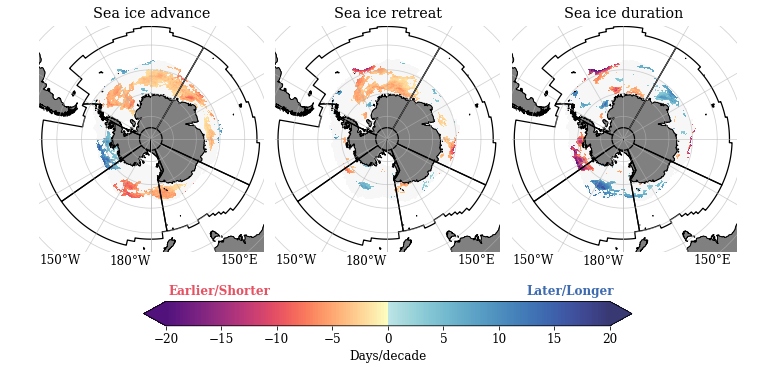

In [74]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))
#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'advance': 'Sea ice advance', 
              'retreat': 'Sea ice retreat', 
              'duration': 'Sea ice duration'}

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -20, vcenter = 0, vmax = 20)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 1,
                       ncols = len(seasonNames))
#Change the width between each plot
gs.update(wspace = 0.05, hspace = 0.45)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, season in enumerate(seasonNames):  
    ax[i] = fig.add_subplot(gs[i], 
                            projection = ccrs.SouthPolarStereo())
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients
    #Standard errors
    se = LM_results[season].std_err

    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 

    #Multiplying by 1000 to get percentages per decade
    p1 = (data*10).where(data != 0).\
    plot.pcolormesh(ax = ax[i], cmap = mymap, transform = ccrs.PlateCarree(),
                    norm = divnorm, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(colors = '#f7f7f7', ax = ax[i], 
                       transform = ccrs.PlateCarree(), add_colorbar = False)
    
    #Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[i])

    #Set title for each subplot.
    ax[i].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    
    #Set map extent
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    gl.ylabels_bottom = True
    gl.xlabels_top = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]
    
#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
              orientation = 'horizontal', 
              shrink = 0.7, pad = 0.06, extend = 'both',
              label = 'Days/decade')

#Add labels to improve readability
#Get colormap to extract colors for labels
cb.ax.text(12.5, 1.25, 'Later/Longer', color = mymap(0.85), fontweight = 'bold')
cb.ax.text(-19.75, 1.25, 'Earlier/Shorter', color = mymap(0.25), fontweight = 'bold')

fn = 'SeasonalLinearTrends_SeaIceSeasonality_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

# Calculating yearly mean values for SIS per sector

In [5]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

In [121]:
#Select the correct time frame: 1979-2017
for key in mod:
    mod[key] = zsf.corrlong(mod[key].sel(time = slice('1979', '2017')))
    obs[key] = obs[key].sel(time = slice('1979', '2017'))

## Splitting data into MEASO regions

In [11]:
#Defining sector names in order
sectorNames = ['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific']

In [12]:
#Loading mask
regions = xr.load_dataarray('MEASO_SIS_3Dmask.nc')

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[i] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific'])

## Clipping longitude corrected data arrays

In [123]:
#Ensuring output folder exists
out_file = varDict['clipped_data']
os.makedirs(out_file, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIS = {}

#Saving each sector as an entry in the dictionary
for season in mod:
    for sector in sectorNames:
        clipped_SIS[f"{sector}_{season}"] = mod[season]*MEASOregions[sector]
        clipped_SIS[f"{sector}_{season}"] = clipped_SIS[f"{sector}_{season}"].rename(season)
        clipped_SIS[f"{sector}_{season}"].to_netcdf(os.path.join(out_file, ('SeaIce-' + sector + '_' + season + '-1979-2018.nc')))

In [92]:
#Removing variables no longer needed
del regions

### Loading data from disk to avoid calculating again

In [13]:
#Clipped data location
out_file = sorted(glob(os.path.join(varDict['clipped_data'], '*.nc')))

#Creating an empty dictionary to load data
clipped_SIS = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in out_file if sec in file]
    #Loop through each season within each sector
    for sea in mod:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).\
        sel(yt_ocean = slice(-90, -50))
        if sec != 'West Pacific':
            clipped_SIS[f'{sec}_{sea}'] = clipped_SIS[f'{sec}_{sea}'].\
            dropna('xt_ocean', how = 'all')

In [12]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
SIS_weighted = {}

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    area_reg = IceArea*MEASOregions[sector]
    #Prepare volume data to be used as weights
    area_reg.name = 'weights'
    #Replace NA values with zeroes
    area_reg = area_reg.fillna(0)
    for season in mod:
        SIS_weighted[f"{sector}_{season}"] = clipped_SIS[f"{sector}_{season}"].\
        weighted(area_reg)
        #Saving weighted means per sector (lon, lat)
        SIS_weighted[f"{sector}_{season}"] = SIS_weighted[f"{sector}_{season}"].\
        mean(('xt_ocean', 'yt_ocean'))

### Plotting yearly means with rolling decadal means
Colourblind palettes were chosen from [https://personal.sron.nl/~pault/#sec:qualitative].

In [17]:
#Create a dictionary to set colors that will be used to represent each sector in all figures
col = ["#4477aa", "#66ccee", "#228833", "#ccbb44", "#ee6677"]
colors = dict(zip(sectorNames, col))

advance Atlantic 0.07647255006144182 -1.894789408428873
advance Central Indian 0.00021057172307606647 -2.6659727984707704
advance East Indian 0.1450882108116723 -1.8535613099988892
advance West Pacific 0.7933416557560256 -0.37451994775534597
advance East Pacific 0.0626623574820245 4.292425992445872
retreat Atlantic 0.32738370742633893 -0.850377330054425
retreat Central Indian 0.9399757039710419 -0.04285629762450422
retreat East Indian 0.543347912571875 -0.7970028274263541
retreat West Pacific 0.8345116607277574 -0.3019693198657212
retreat East Pacific 0.9434303826363027 0.1505370929824756
duration Atlantic 0.5000997513752623 0.9626746680705625
duration Central Indian 0.004705764680624084 2.59528726021649
duration East Indian 0.5421048381342527 1.0751392454218898
duration West Pacific 0.9747170293312314 0.06511682267882311
duration East Pacific 0.036867261989350905 -4.332407890090021


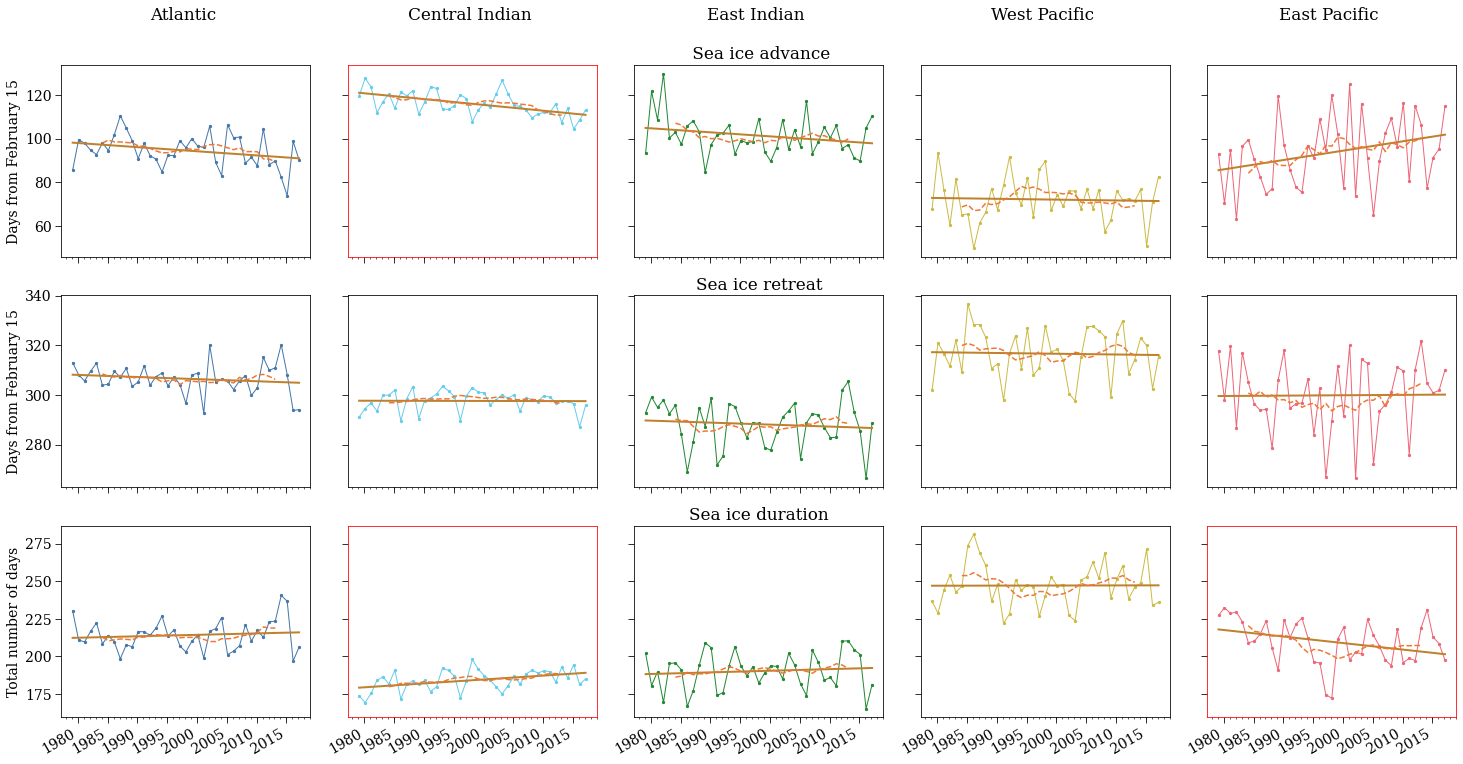

In [20]:
#Maximum and minimum values for the years when plotting    
maxV = SIS_weighted['Atlantic_advance'].indexes['time'].year.max()
minV = SIS_weighted['Atlantic_advance'].indexes['time'].year.min()

#Initialise figure
fig = plt.figure(figsize = (25, 12))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create a grid inside the figure with seasons defining the number of rows and one column
gs = gridspec.GridSpec(nrows = 3, ncols = 1)

#Creating subgrid per row (sea ice seasons)
for i, season in enumerate(seasonNames):
    #Create a list to hold axes information for every row. Each row will contain the same amount of plots as there are sectors.
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    #Create a subgrid for each row in the main grid. Each row will contain the same amount of plots as there are sectors. Decrease blank space between plots
    si_season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames),
                                                 subplot_spec = gs[i], wspace = 0.15)
    
    #Plotting figures in each grid cell (row wise)
    for j, sec in enumerate(sectorNames):
        #Initilise figures in each grid cell. Ensure x and y axes are shared across the entire row
        ax = plt.Subplot(fig, si_season[0, j], sharex = axes[0, 0], sharey = axes[0, 0])
        fig.add_subplot(ax)
        #Adding local axis value to empty axes list 
        axes[0, j] = ax
        data = SIS_weighted[f'{sec}_{season}']
        #Calculating yearly means per sector and per season, and plotting them
        data.plot(ax = ax, linewidth = 1, marker = 'o', markersize = 2.25, 
                  color = colors[sec])
        slope, inter, rval, pval, se = ss.linregress(data.time.dt.year.values, 
                                                     data.values)
        plt.plot(data.time.values, inter+(slope*data.time.dt.year.values), 
                 label = f'Trend line {sec} (p = {round(pval, 3)})', 
                 color = '#bf812d', linewidth = 2)
        #Calculate the rolling decadal mean per sector and season
        SIS_weighted[f'{sec}_{season}'].rolling(time = 10, center = True).\
        mean().dropna('time').plot(ax = ax, color = '#ee7733', linestyle = '--')
        #Remove x axis label
        ax.set_xlabel('')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
        #Specifying how figure titles should appear in each grid cell
        if season == 'advance' and sec == sectorNames[2]:
            ax.set_title(f'{sec} \n \n Sea ice {season}')
        elif season == 'advance' and sec != sectorNames[2]: 
            ax.set_title(f'{sec} \n \n')
        elif season != 'advance' and sec == sectorNames[2]:
            ax.set_title(f'Sea ice {season}')
        else:
            ax.set_title('')
        #Show x tick labels only in the last row
        if season != 'duration':
            ax.set_xticklabels([])
        #Include the y axis title and labels only for the first column
        if sec == sectorNames[0] and season != 'duration':
            ax.set_ylabel('Days from February 15')
        #The last row of the first column has a different axis title
        elif sec == sectorNames[0] and season == 'duration':
            ax.set_ylabel('Total number of days')
        #Remove all y labels and titles in any other grid cell
        else:
            ax.set_ylabel('')
            ax.yaxis.set_tick_params(labelleft = False) 
        print(season, sec, pval, slope*10)
        if pval < 0.05:
            for pos in ['top', 'bottom', 'right', 'left']:
                ax.spines[pos].set_edgecolor('red')

# fn = 'SeaIceTrends_MEASOsectors_' + str(minV) + '-' + str(maxV)

# #Saving final figure
# plt.savefig(os.path.join(varDict['lm_fig'], fn), dpi = 300, bbox_inches = 'tight', 
#             pad_inches = 0.05)